# Example Notebook for pyBSM Perturbations

This example notebook demonstrates how to run an example image through a series of perturbations of various sensor and scenario parameters in order to see how those parameters affect image quality.

## Table of Contents
* [Set Up the Environment](#environment-setup)
* [Specify Sample Image and Metadata Parameters](#sample-input-image)
* [Simulate Original Image](#simulate-original-image)
* [Select Perturbation Parameters](#select-parameters)
* [Simulate Perturbed Images](#simulate-perturbations)


## Set Up the Environment <a name="environment-setup"></a>

In [ ]:
!{sys.executable} -m pip install -qU pip
print("Installing Pillow...")
!{sys.executable} -m pip install -q "Pillow>=10.3.0"

In [1]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import yaml
from PIL import Image

from pybsm import simulation
from pybsm.simulation import Scenario, Sensor

## Specify Sample Image and Metadata Parameters <a name="sample-input-image"></a>

To get started, you need to provide an image, the ground sample distance (gsd) of that image, and the sensor's estimated altitude (in meters) when the image was captured.

First, a RefImage object is created to store the image and metadata for the original image. If you do not have all the metadata parameters for a sensor, you can use the estimate_capture_parameters function to approximate those parameters given an altitude.

In [2]:
config_path = "./config/pybsm_example_config.yaml"
with open(config_path) as file:
    config = yaml.safe_load(file)

img_filename = config["filepath"]
img = np.asarray(Image.open(img_filename))

gsd = config["gsd"]
ref_img = simulation.RefImage(img, gsd)

# estimate sensor and scenario parameters
sensor, scenario = ref_img.estimate_capture_parameters(altitude=config["scenario"]["altitude"])

## Simulate Original Image <a name="simulate-original-image"></a>

Using the sensor and scenario objects with the estimated parameters of the original image, we generate an image that should be as close as possible to the original image. After we generate a simulated image, we stretch the contrast of both images to match the colors in the images.

/data/barry.ravichandran/XAITK/JATIC/pybsm/src/pybsm/otf/functional.py:152: RuntimeWarning: divide by zero encountered in divide
  np.arccos(rho / eta / r0) - (rho / eta / r0) * np.sqrt(1.0 - (rho / eta / r0) ** 2.0)
/data/barry.ravichandran/XAITK/JATIC/pybsm/src/pybsm/otf/functional.py:152: RuntimeWarning: invalid value encountered in divide
  np.arccos(rho / eta / r0) - (rho / eta / r0) * np.sqrt(1.0 - (rho / eta / r0) ** 2.0)
/data/barry.ravichandran/XAITK/JATIC/pybsm/src/pybsm/otf/functional.py:160: RuntimeWarning: divide by zero encountered in divide
  phi = np.arccos((1.0 + eta**2.0 - (2.0 * rho / r0) ** 2) / 2.0 / eta)
/data/barry.ravichandran/XAITK/JATIC/pybsm/src/pybsm/otf/functional.py:160: RuntimeWarning: invalid value encountered in divide
  phi = np.arccos((1.0 + eta**2.0 - (2.0 * rho / r0) ** 2) / 2.0 / eta)


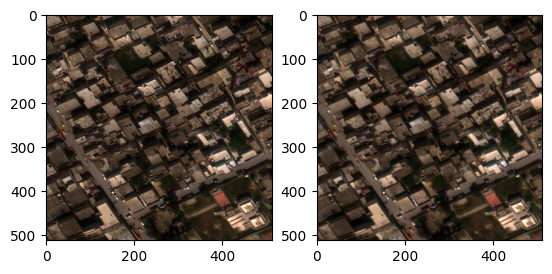

In [3]:
# Note this spits out a bunch of divide by zero errors.
img_out = simulation.simulate_image(ref_img, sensor, scenario)[2]
img_out = simulation.stretch_contrast_convert_8bit(img_out)

plt.figure()
ax1 = plt.subplot(1, 2, 1)
plt.imshow(simulation.stretch_contrast_convert_8bit(ref_img.img))
ax2 = plt.subplot(1, 2, 2)
plt.imshow(img_out)
plt.show()

## Select Perturbation Parameters <a name="select-parameters"></a>

Now that we have a set of parameters that accurately re-creates the source image, we can start to perturb the parameters and see how they affect the image. In this example notebook, we choose one parameter from the sensor and one from the scenario objects to illustrate how they affect the images.

To compare the effect of a parameter on the image quality, we use this function to create a series of sensor and scenario instances with varying parameter values.

In [4]:
def niirs_vs_range(
    sensor: Sensor,
    scenario: Scenario,
    ranges: np.ndarray,
    parameter: str,
) -> list[tuple[Sensor, Scenario]]:
    """
    Creates of series and scenario objects with varying ``parameter`` values

    :param sensor:
        The base sensor object
    :param scenario:
        The base scenario object
    :param: ranges:
        ``parameter`` values to vary
    :param: parameter:
        The sensor/scenario parameter to vary. Currently limited to ground range or f

    :return:
        List of modified sensor and scenario objects equivalent to length of ``ranges``
    """
    # this function allows us to iterate through each ground range
    myobj = []
    for r in ranges:
        if parameter == "ground_range":
            new_scenario = copy.deepcopy(scenario)
            new_scenario.ground_range = r
            metrics = (sensor, new_scenario)
            myobj.append(metrics)
        elif parameter == "f":
            new_sensor = copy.deepcopy(sensor)
            new_sensor.f = r
            metrics = (new_sensor, scenario)
            myobj.append(metrics)
    return myobj

## Simulate Perturbed Images <a name="simulate-perturbations"></a>

Finally, we set a range of values for the parameters we wish to perturb (ground range and focal length) and simulate an image using each of those values. Plots are generated below that compare the image generated from each set of parameters alongside the original unaltered image.

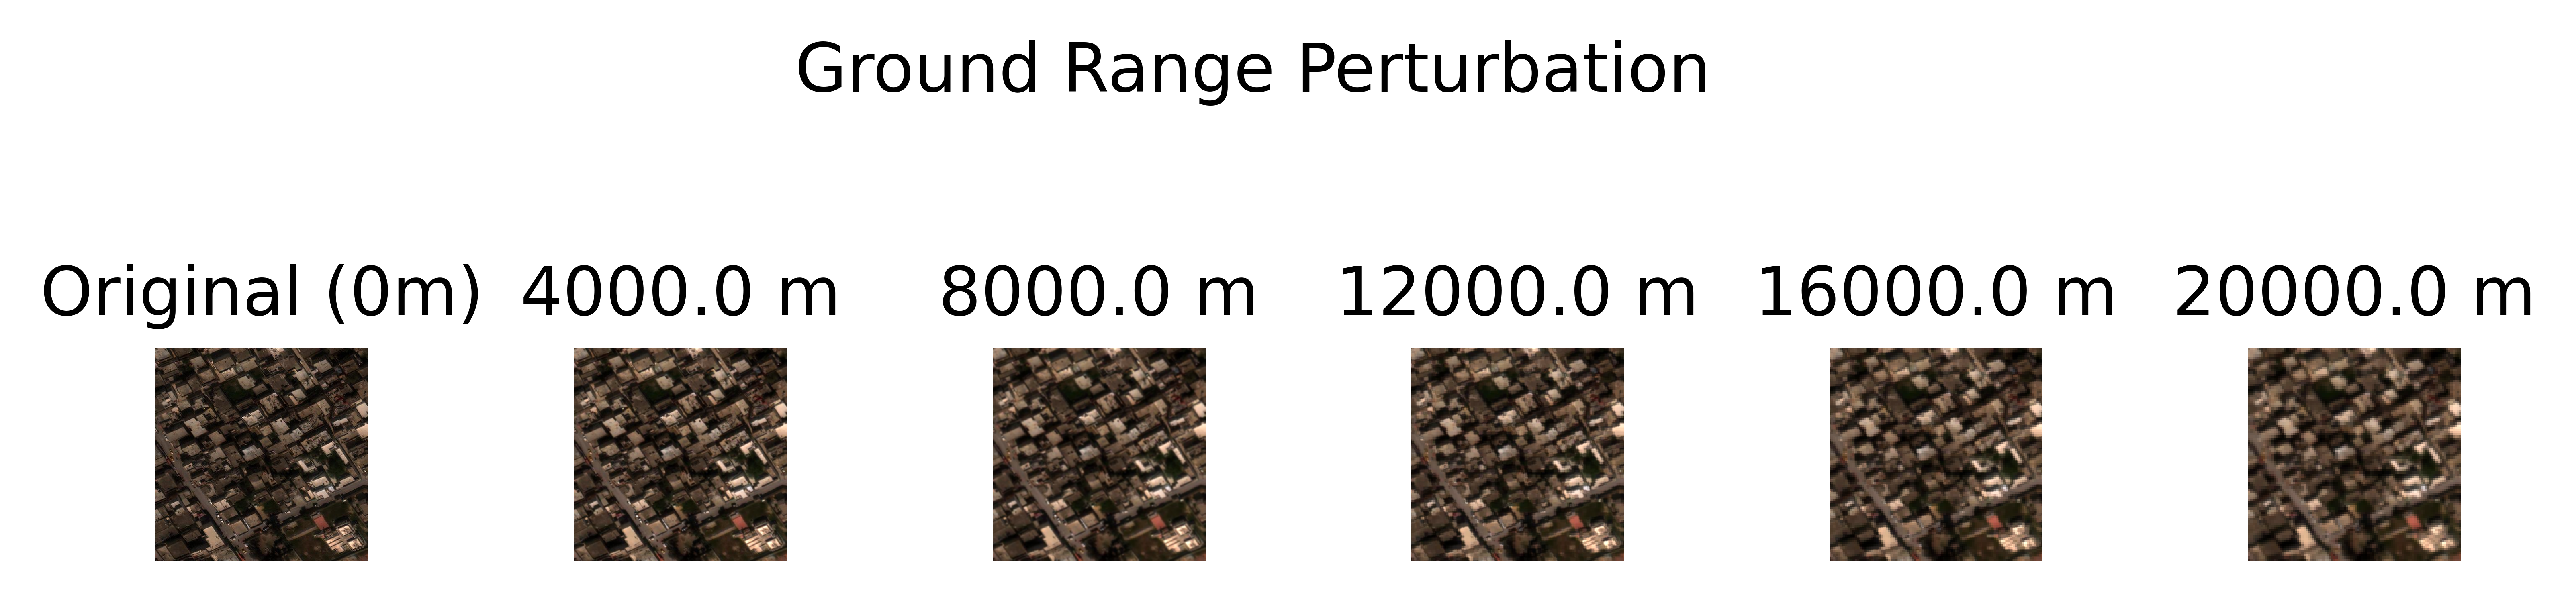

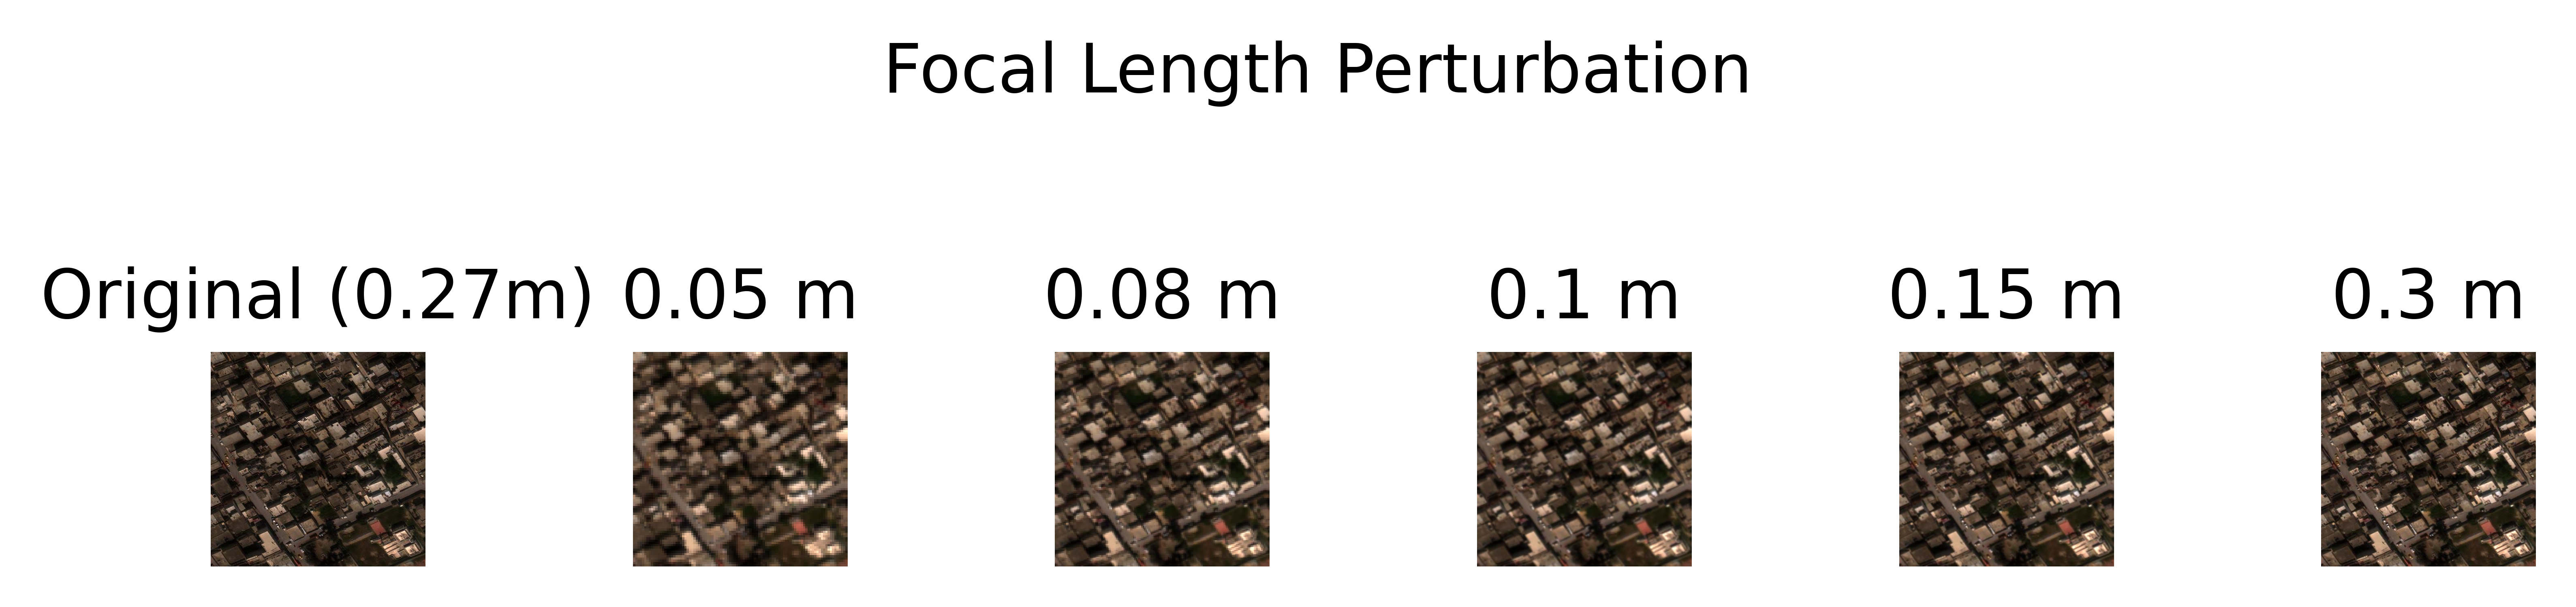

In [5]:
ground_range_range = np.arange(0, 24e3, 4e3)
f_range = [0.05, 0.08, 0.1, 0.15, 0.3]

# compute the niirs metrics fromt the scenario and sensor parameters
metrics = niirs_vs_range(sensor, scenario, ground_range_range, "ground_range")

# display sequence of degraded images as a function of ground range
fig, axarr = plt.subplots(nrows=1, ncols=6)
fig.set_dpi(1000)
fig.tight_layout()
fig.subplots_adjust(top=1.45)
fig.suptitle("Ground Range Perturbation")
plt.subplot(1, 6, 1)
plt.axis("off")
plt.title("Original (" + str(scenario.ground_range) + "m)")
axarr[0].imshow(ref_img.img)

idx = 1  # index for the subplots
for ii in np.arange(1, len(ground_range_range)):  # index starts at 4 because the
    # shorter range images would have a GSD less than imggsd
    plt.subplot(1, 6, idx + 1)
    plt.axis("off")
    idx = idx + 1
    plt.title(str(ground_range_range[ii]) + " m")

    _, _, img_out = simulation.simulate_image(ref_img, metrics[ii][0], metrics[ii][1])
    img_out = simulation.stretch_contrast_convert_8bit(img_out)
    plt.imshow(img_out)
plt.show()

metrics = niirs_vs_range(sensor, scenario, f_range, "f")

# display sequence of degraded images as a function of ground range
fig2, axarr2 = plt.subplots(nrows=1, ncols=6)
fig2.set_dpi(1000)
fig2.tight_layout()
fig2.subplots_adjust(top=1.45)
fig2.suptitle("Focal Length Perturbation")
plt.subplot(1, 6, 1)
plt.axis("off")
plt.title("Original (" + str(round(sensor.f, 2)) + "m)")
axarr2[0].imshow(ref_img.img)

idx = 1  # index for the subplots
for ii in np.arange(len(f_range)):  # index starts at 4 because the
    # shorter range images would have a GSD less than imggsd
    plt.subplot(1, 6, idx + 1)
    plt.axis("off")
    idx = idx + 1
    plt.title(str(f_range[ii]) + " m")

    _, _, img_out = simulation.simulate_image(ref_img, metrics[ii][0], metrics[ii][1])
    img_out = simulation.stretch_contrast_convert_8bit(img_out)
    plt.imshow(img_out)
plt.show()